#Preliminary settings

In [ ]:
# import
import os
from google.colab import drive
import gdown

import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import applications
from keras import optimizers

from keras.utils.vis_utils import plot_model

In [ ]:
drive.mount('/content/drive')
model_dir = '/content/drive/MyDrive/Exercise07_finetuning_augmentation/'

Mounted at /content/drive


#Dataset

##Download and unzip

In [ ]:
# download and unzip the dataset
url = 'https://drive.google.com/uc?id=1Lnj_Cyx8fa3QQ_8QohHEC626JP7dKDlL'
gdown.download(url, 'dogs_vs_cats.zip', quiet=False)

! unzip -q -n dogs_vs_cats.zip
! echo 'Training folder content'
! ls -l ./dogs_vs_cats/train/
! echo 'Validation folder content'
! ls -l ./dogs_vs_cats/validation/

Downloading...
From: https://drive.google.com/uc?id=1Lnj_Cyx8fa3QQ_8QohHEC626JP7dKDlL
To: /content/dogs_vs_cats.zip
100%|██████████| 572M/572M [00:02<00:00, 204MB/s]


Training folder content
total 536
drwxr-xr-x 2 root root 278528 Feb 19  2018 cat
drwxr-xr-x 2 root root 270336 Feb 19  2018 dog
Validation folder content
total 168
drwxr-xr-x 2 root root 90112 Feb 19  2018 cat
drwxr-xr-x 2 root root 81920 Feb 19  2018 dog


###Useful variables

In [ ]:
# set the paths
train_data_dir = 'dogs_vs_cats/train/'
val_data_dir = 'dogs_vs_cats/validation/'

# training parameters
nb_train_samples = 20000
nb_val_samples = 5000

##Show some examples

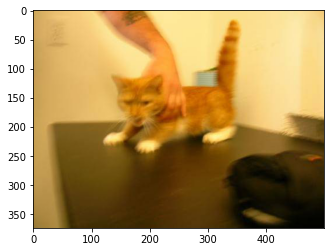

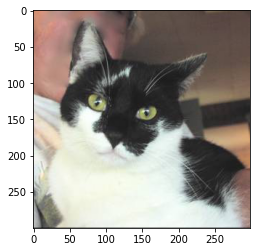

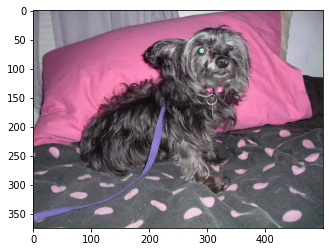

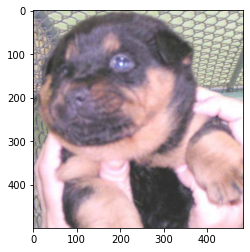

In [ ]:
plt.figure()
plt.imshow(PIL.Image.open('dogs_vs_cats/train/cat/cat.0.jpg'))

plt.figure()
plt.imshow(PIL.Image.open('dogs_vs_cats/train/cat/cat.999.jpg'))

plt.figure()
plt.imshow(PIL.Image.open('dogs_vs_cats/train/dog/dog.0.jpg'))

plt.figure()
plt.imshow(PIL.Image.open('dogs_vs_cats/train/dog/dog.999.jpg'))

##Preprocessing and Augmentations
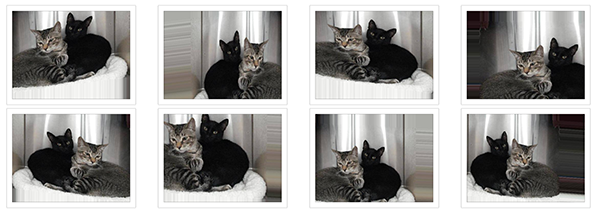


First of all, define the Keras generators to read data from the disk.

A generator produces data to be fed to the network. On-the-fly operations can be performed on these data before to fed them to the network, like data normalization/rescaling (e.g., divide by 255).

For the training set only, we define special kind of preprocessing operations called *data augmentations*. These produce a slightly different version of the training samples, generally without changing their class/label.

The augmentation works as follow:
*   every time an image file is read from the disk, one or more transformations may be applied before to feed the image to the network;
*   the transformation(s) to apply may be randomly selected;
*   the transformation parameter values may be randomly drawn from a predefined interval;
*   generally, none of these transformations affect the target/label of the images (i.e. the transformations generate a slightly different sample of the same class).

At each epoch, new samples are randomly/dinamically generated (without saving them as files) so as to virtually augment the training set.
Augmentation is crucial to:
*   combat overfitting, expecially when the training size is small;
*   increase robustness against some kind of distortions, which are simulated by using transformations, in particular when the training set lacks samples containing that kind of distortion.

Some examples are shown [here](https://fairyonice.github.io/Learn-about-ImageDataGenerator.html).

In [ ]:
### DATA GENERATOR
# get data from the folder, perform the preprocessing and the data augmentation,
# and arranges them in batches

# this is the preprocessing configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,     # rescale
    shear_range=0.2,      # on-the-fly data augmentation
    zoom_range=0.2,       # on-the-fly data augmentation
    horizontal_flip=True) # on-the-fly data augmentation

# this is the preprocessing configuration we will use for validation:
# rescaling only
val_datagen = ImageDataGenerator(rescale=1. / 255)

##Flow from directory
We set the generator parameters to read data from the previously unzipped dataset directory.

We also set the image size, that is the size at which images must be resized in order to match the network input size.
This is necessary since images in our dataset have different resolutions.

Finally, we set the number of images to be processed at the same time, i.e. the batch size.

In [ ]:
img_width, img_height = 150, 150  # resize dimensions of our images
batch_size = 8                    # number of images in a batch

print('Training set generator:')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),  # resize the image in order to match the network input size
    batch_size=batch_size,
    class_mode='binary')                  # set to 'categorical' for multi-class problems

print('Validation set generator:')
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),  # resize the image in order to match the network input size
    batch_size=batch_size,
    class_mode='binary')                  # set to 'categorical' for multi-class problems

Training set generator:
Found 20000 images belonging to 2 classes.
Validation set generator:
Found 5000 images belonging to 2 classes.


#Train a custom network for binary classification

For binary classifiers, we can further reduce the number of training parameters by using the Keras [Binary CrossEntropy loss](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) instead of the [Categorical CrossEntropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) one.
This requires the following modifications to the last fully-connected layer:
1.   set the output number of neurons equal to `1` instead of `2`;
2.   replace the activation function from `'softmax'` to `'sigmoid'`;
3. replace the data generator `class_mode` parameter from `'categorical'` to `'binary'` (as done in the previous cell).

Note that the step 1. halfen the amount of training parameters of the last fully-connected layer.

##Define a sequential CNN

In [ ]:
### NETWORK MODEL

input_shape = (img_width, img_height, 3)

custom_model = Sequential()
custom_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(32, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(64, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Flatten())
custom_model.add(Dense(64))
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))

# Output layer
# In case of a binary classification problem it is possible to use the
# binary cross-entropy loss instead of the cross-entropy. This requires that the
# output number of neurons is equal to 1 (meanwhile for the cross-entropy loss
# it is equal to the number of classes).
custom_model.add(Dense(1))                      # set to number of classes for multi-class problems
custom_model.add(Activation('sigmoid'))         # set to 'softmax' for multi-class problems

custom_model.compile(loss='binary_crossentropy',# set to 'categorical_crossentropy' for multi-class problems
              optimizer='rmsprop',
              metrics=['accuracy'])

##Training from scratch
For custom networks, weights are randomly initialized.
In deep learning, training a network starting from these random weights is called *from scratch*. It usually requires a lot of data.

In [ ]:
### TRAINING FROM SCRATCH
# This is slow: we will need 20 training epochs to converge

epochs = 20

custom_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_val_samples // batch_size)

save_model(custom_model, model_dir + 'custom_model')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
2500/2500 [==============================] - 184s 69ms/step - loss: 0.6545 - accuracy: 0.6323 - val_loss: 0.5939 - val_accuracy: 0.6924
Epoch 2/20
2500/2500 [==============================] - 178s 71ms/step - loss: 0.5717 - accuracy: 0.7221 - val_loss: 0.5004 - val_accuracy: 0.7580
Epoch 3/20
2500/2500 [==============================] - 176s 71ms/step - loss: 0.5419 - accuracy: 0.7470 - val_loss: 0.5281 - val_accuracy: 0.7560
Epoch 4/20
2500/2500 [==============================] - 175s 70ms/step - loss: 0.5187 - accuracy: 0.7598 - val_loss: 0.5034 - val_accuracy: 0.7658
Epoch 5/20
 898/2500 [=========>....................] - ETA: 1:42 - loss: 0.5114 - accuracy: 0.7641

KeyboardInterrupt: ignored

##Validation
Download already trained weights and compute performance on the validation set.

In [ ]:
custom_model = load_model(model_dir + 'custom_model')

In [ ]:
# perform the validate on the validation set
print('Performing validation:')
results = custom_model.evaluate_generator(val_generator, nb_val_samples // batch_size)
for i,m in enumerate(custom_model.metrics_names):
  print('\t%s: %f' % (m, results[i]))

Performing validation:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


	loss: 0.467681
	accuracy: 0.822000


# Fine tuning from a **pre-trained** network
Load a pre-trained network and fine-tune (re-train) its top-most layers.

In [ ]:
# ResNet50 with pre-trained weights
from keras.applications import resnet
base_model = resnet.ResNet50(weights='imagenet', include_top=False)
train_after_layer = 25  # only train the layers after the 25th

In [ ]:
# Inception V3 with pre-trained weights
from keras.applications import inception_v3
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
train_after_layer = 50 # only train the layers after the 50th

In [ ]:
# Xception with pre-trained weights
from keras.applications import xception
base_model = xception.Xception(weights='imagenet', include_top=False)
train_after_layer = 25 # only train the layers after the 25th

83697664/83683744 [==============================] - 1s 0us/step


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (137293730 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


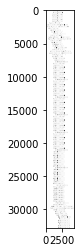

In [ ]:
base_model.summary()
plot_model(base_model, to_file='xception_plot.png', dpi=1200, show_shapes=True, show_layer_names=True)
plt.imshow(PIL.Image.open('xception_plot.png'))

##Build the new network model
We use the Keras [Model](https://keras.io/models/model/) to define a network by using the [functional API](https://keras.io/guides/functional_api/).
This is useful when we need to modify an existing network architecture. It is also used to define *non-sequential* network models.

In our case, we simply wants to connect the `base_model` output to the input of a new classification stage composed by a *Global Average Pooling* and a *Fully connected* (Dense) layer that outputs a number of neurons equal to the number of classes of our problem.

In [ ]:
### CHANGE THE TOP MODEL BLOCK
# this is a common practice due to the fact that the pre-trained network is
# usually trained for a different classification problem (i.e. with a different
# number of classes). We need to replace the output layer in order to match the
# number of classes of our problem (equals to 2).

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(units=1, activation='sigmoid')(x) # set to units=num_classes and activation='softmax' for multi-class classification problems

# Add your top layer block
model = Model(base_model.input, predictions)

In [ ]:
# set the first K layers (up to the last conv block)
# to non-trainable (weights will not change during training)
for layer in model.layers[:train_after_layer]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',  # 'categorical_crossentropy' for multi-class problems
              optimizer=optimizers.gradient_descent_v2.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

In [ ]:
### DATA GENERATOR (again)
# we comment-out the resize of the image so that each input image will be
# automatically resized in order to match the pre-trained network input size

print('Training set generator:')
train_generator_ = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),   # network input size changed
    batch_size=batch_size,
    class_mode='binary')

print('Training set generator:')
val_generator_ = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(256, 256),   # network input size changed
    batch_size=batch_size,
    class_mode='binary')

Training set generator:
Found 20000 images belonging to 2 classes.
Training set generator:
Found 5000 images belonging to 2 classes.


In [ ]:
### FINE-TUNING
# This is fast: one training epoch is sufficient to converge

epochs_fine = 1

model.fit_generator(
    train_generator_,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs_fine,
    validation_data=val_generator_,
    validation_steps=nb_val_samples // batch_size)

save_model(model, model_dir + 'finetuned')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


 630/2500 [======>.......................] - ETA: 5:20 - loss: 0.5467 - accuracy: 0.8103

KeyboardInterrupt: ignored

##Validation
Download already trained weights and compute performance on the validation set.

In [ ]:
# LOAD WEIGHTS AND VALIDATE
from keras.models import load_model
for model_file in ('finetuned_resnet50', 'finetuned_xception'):
  M = load_model(model_dir + model_file)

  print('Performing validation for the model "%s":' % model_file)
  results = M.evaluate_generator(val_generator, nb_val_samples // batch_size)
  for i,m in enumerate(M.metrics_names):
    print('\t%s: %f' % (m, results[i]))

Performing validation for the model "finetuned_resnet50":


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


	loss: 0.347339
	accuracy: 0.867200
Performing validation for the model "finetuned_xception":
	loss: 0.148467
	accuracy: 0.935800
